In [1]:
# # Install the required libraries
# #SAM
# %pip install git+https://github.com/facebookresearch/segment-anything.git
# #Transformers
# %pip install -q git+https://github.com/huggingface/transformers.git
# #Datasets to prepare data and monai if you want to use special loss functions
# %pip install datasets
# %pip install -q monai
# #Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
# %pip install patchify
# # Nibabel to load nifti files
# %pip install nibabel

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

# Loading data

## Load and Preprocess Data

### Female Mice dataset

In [3]:
import os
import nibabel as nib
import numpy as np
from skimage import color
from tqdm import tqdm

# paths to the images and labels directories
# images_path = '/Users/rishienandhan/Desktop/Deep Learning/datasets/FemaleMice/images'
# labels_path = '/Users/rishienandhan/Desktop/Deep Learning/datasets/FemaleMice/labels'
images_path = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/FemaleMice/images'
labels_path = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/FemaleMice/labels'

large_images = []
large_masks = []

In [4]:
# Iterate through all files
for image_file in tqdm(os.listdir(images_path)):
    # print(image_file)
    if image_file.endswith('.nii'):
        # Load the image
        image_nifti = nib.load(os.path.join(images_path, image_file))
        image_data = image_nifti.get_fdata()

        # Convert to grayscale
        if image_data.ndim == 3 and image_data.shape[2] == 3:
            image_gray = color.rgb2gray(image_data)
        else:
            image_gray = image_data

        large_images.append(image_gray)

        # get the corresponding label filename
        label_file = image_file.replace('.nii', '-label.nii')
        label_nifti = nib.load(os.path.join(labels_path, label_file))
        label_data = label_nifti.get_fdata()

        large_masks.append(label_data)



  0%|                                                                                           | 0/23 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:10<00:00,  2.10it/s]


In [5]:
# convert to numpy arrays
large_images = np.array(large_images)
large_masks = np.array(large_masks)

print(f'Images shape: {large_images.shape}')
print(f'Masks shape: {large_masks.shape}')

Images shape: (23, 4096, 4096)
Masks shape: (23, 4096, 4096)


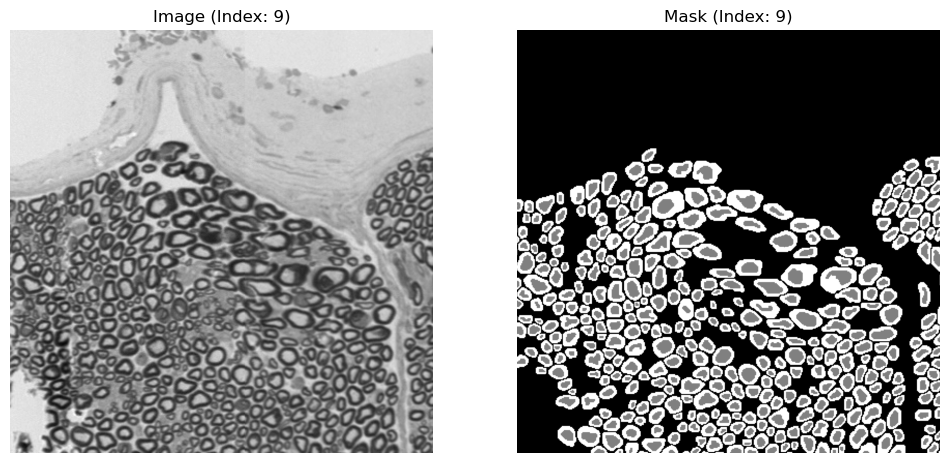

In [6]:
# Visualize a sample image and mask
random_index = np.random.randint(large_images.shape[0])

selected_image = large_images[random_index]
selected_mask = large_masks[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

In [7]:
np.unique(selected_mask)

array([0., 1., 2.])

In [8]:
# Convert:
# - Values of 1 to 0 (background)
# - Values of 2 to 1 (myelin mask)
# - Keep 0 as background
binary_masks = np.where(large_masks == 1, 0, large_masks)
binary_masks = np.where(binary_masks == 2, 1, binary_masks)

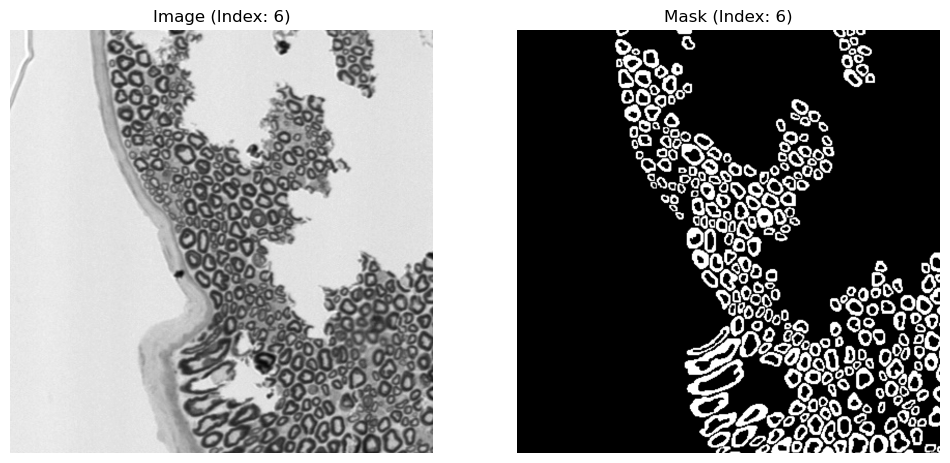

In [9]:
# Visualize a sample image and mask
random_index = np.random.randint(binary_masks.shape[0])

selected_image = large_images[random_index]
selected_mask = binary_masks[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

In [10]:
print(large_images.shape)
print(binary_masks.shape)

(23, 4096, 4096)
(23, 4096, 4096)


### Macaque dataset

In [11]:
import os
import numpy as np
import nibabel as nib

# Paths
# base_path = '/Users/rishienandhan/Desktop/Deep Learning/datasets/Macaque'
base_path = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/Macaque'
data_path = os.path.join(base_path, 'data')
mask_path = os.path.join(base_path, 'segmentation')

# Folder names
sample_folders = ['sample1', 'sample2', 'sample3', 'sample5', 'sample6', 'sample7', 'sample8']

# Initialize lists to store images and masks
images = []
masks = []

In [12]:
# Load images and masks
for sample in tqdm(sample_folders):
    # Load image
    img_path = os.path.join(data_path, sample)
    img_files = [f for f in os.listdir(img_path) if f.endswith('.nii') or f.endswith('.nii.gz')]
    if img_files:
        img_file = img_files[0]  # Assuming there is only one NIfTI file per folder
        img_nib = nib.load(os.path.join(img_path, img_file))
        image_data = img_nib.get_fdata()
        image_data = np.squeeze(image_data)
        images.append(image_data)

    # Load mask
    mask_path_sample = os.path.join(mask_path, sample)
    mask_files = [f for f in os.listdir(mask_path_sample) if f.endswith('.nii') or f.endswith('.nii.gz')]
    if mask_files:
        mask_file = mask_files[0]  # Assuming there is only one mask per folder
        mask_nib = nib.load(os.path.join(mask_path_sample, mask_file))
        mask_data = mask_nib.get_fdata()
        mask_data = np.squeeze(mask_data)
        masks.append(mask_data)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.93it/s]


In [13]:
# convert to numpy arrays
large_images_2 = np.array(images)
large_masks_2 = np.array(masks)

print('Images shape:', large_images_2.shape)
print('Masks shape:', large_masks_2.shape)

Images shape: (7, 2300, 3040)
Masks shape: (7, 2300, 3040)


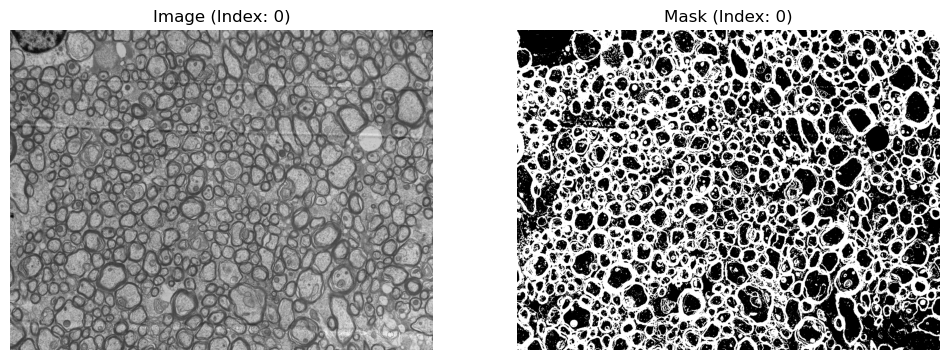

In [14]:
# Visualize a sample image and mask
random_index = np.random.randint(large_images_2.shape[0])

selected_image = large_images_2[random_index]
selected_mask = large_masks_2[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

In [15]:
print(large_images_2.shape)
print(large_masks_2.shape)

(7, 2300, 3040)
(7, 2300, 3040)


### AimSeg dataset

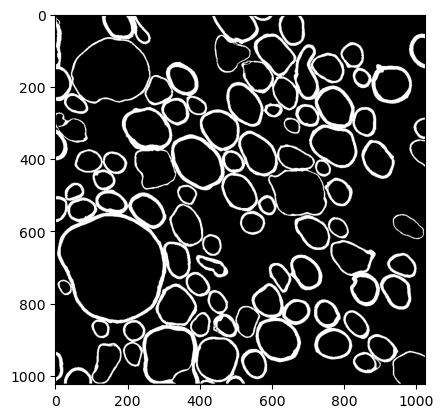

In [16]:
# Images from AimSeg
aim_seg_images = []
# Iterate through Images and import all images as tiffs to an array
# directory_string = "/Users/rishienandhan/Desktop/Deep Learning/datasets/AimSeg/Images/"
directory_string = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/AimSeg/Images/'
directory = os.fsencode(directory_string)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    img = tifffile.imread(directory_string + str(filename))
    img_norm = img #/ np.linalg.norm(img)
    y = np.shape(img_norm)[0]
    x = np.shape(img_norm)[1]
    if y < 1024:
        img_norm = np.pad(img_norm, ((0, 1024 - y),(0, 0)))
    if x < 1024:
        img_norm = np.pad(img_norm, ((0, 0),(0, 1024 - x)))
    aim_seg_images.append(img_norm)

# Masks from AimSeg
aim_seg_masks = []
# Iterate through labels and import all images as tiffs to another array
# directory_string = "/Users/rishienandhan/Desktop/Deep Learning/datasets/AimSeg/GroundTruth_Semantic/"
directory_string = 'C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/AimSeg/GroundTruth_Semantic/'
directory = os.fsencode(directory_string)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    img = tifffile.imread(directory_string + str(filename))
    y = np.shape(img)[0]
    x = np.shape(img)[1]
    if y < 1024:
        img = np.pad(img, ((0, 1024 - y),(0, 0)))
    if x < 1024:
        img = np.pad(img, ((0, 0),(0, 1024 - x)))
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            if img[i][j] == 1.:
                img[i][j] = 1
            else:
                img[i][j] = 0
    aim_seg_masks.append(img)


plt.imshow(aim_seg_masks[0], cmap='gray')
plt.show()

In [17]:
large_images_3 = np.array(aim_seg_images)
large_masks_3 = np.array(aim_seg_masks)

In [18]:
print(large_images_3.shape)
print(large_masks_3.shape)

(8, 1024, 1024)
(8, 1024, 1024)


### AxonDeepSeg dataset

In [19]:
from PIL import Image

In [20]:
# Images from Axon Deep Seg
ads_images = []
ads_masks = []
directory_string = "C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/DeepAxonSeg/data/"
# directory_string = "/Users/rishienandhan/Desktop/Deep Learning/datasets/DeepAxonSeg/data/"
directory = os.fsencode(directory_string)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    img = Image.open(directory_string + str(filename)).convert('L')
    ads_images.append(img)

# Masks from Axon Deep Seg
directory_string = "C:/Users/andre/Documents/NYU Tandon/Spring 2024/Deep Learning/datasets/DeepAxonSeg/labels/"
# directory_string = "/Users/rishienandhan/Desktop/Deep Learning/datasets/DeepAxonSeg/labels/"
directory = os.fsencode(directory_string)
for i, file in enumerate(os.listdir(directory)):
    filename = os.fsdecode(file)
    img = np.array(Image.open(directory_string + str(filename)).convert('L'))
    for i in range(np.shape(img)[0]):
        for j in range(np.shape(img)[1]):
            if img[i][j] >= 230:
                img[i][j] = 1
            else:
                img[i][j] = 0
    ads_masks.append(img)

10
10


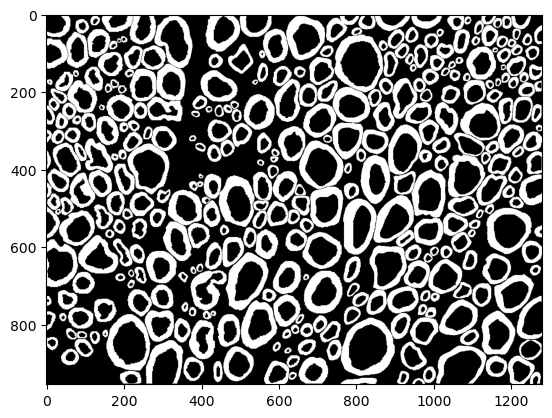

array([0, 1], dtype=uint8)

In [21]:
print(len(ads_images))
print(len(ads_masks))
plt.imshow(ads_masks[1], cmap='gray')
plt.show()
np.unique(ads_masks[1])

## Patchify

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

Rationale behind 720 patch size: We consider multiple dataset sources with different image sizes. We must make sure the smallest image dimension across all datasets is atmost the size of the chosen patch size. 

In [22]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [23]:
def patch_large_image(large_images, large_masks):
    all_img_patches = []
    for img in range(large_images.shape[0]):
        large_image = large_images[img]
        patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap
    
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
    
                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)
    
    images = np.array(all_img_patches)
    
    #Let us do the same for masks
    all_mask_patches = []
    for img in range(large_masks.shape[0]):
        large_mask = large_masks[img]
        patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap
    
        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):
    
                single_patch_mask = patches_mask[i,j,:,:]
                single_patch_mask = (single_patch_mask).astype(np.uint8) #/ 255.
                all_mask_patches.append(single_patch_mask)
    
    masks = np.array(all_mask_patches)
    return images, masks

### Generate Patches

Female mice dataset:

In [24]:
images_1, masks_1 = patch_large_image(large_images, binary_masks)

In [25]:
print(images_1.shape)
print(masks_1.shape)

(5888, 256, 256)
(5888, 256, 256)


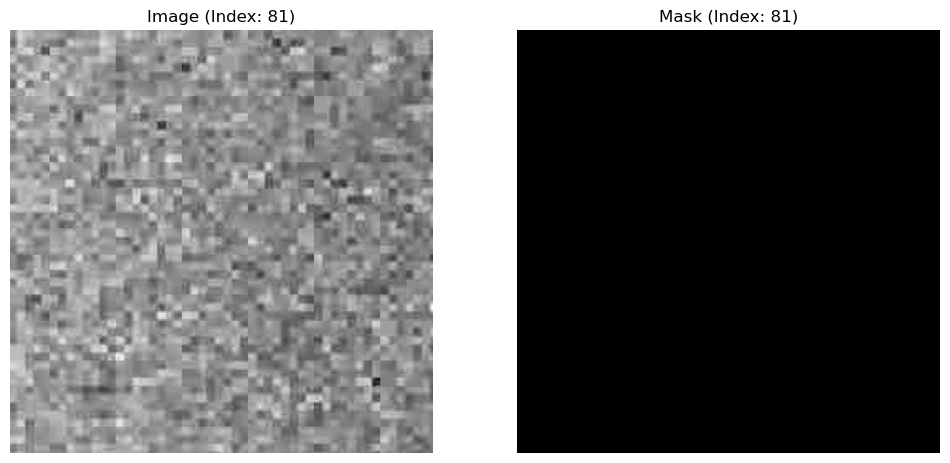

In [26]:
# Visualize a sample image and mask
random_index = np.random.randint(images_1.shape[0])

selected_image = images_1[random_index]
selected_mask = masks_1[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

Macaque dataset:

In [27]:
print(large_images_2.shape)
print(large_masks_2.shape)

(7, 2300, 3040)
(7, 2300, 3040)


In [28]:
images_2, masks_2 = patch_large_image(large_images_2, large_masks_2)

In [29]:
print(images_2.shape)
print(masks_2.shape)

(616, 256, 256)
(616, 256, 256)


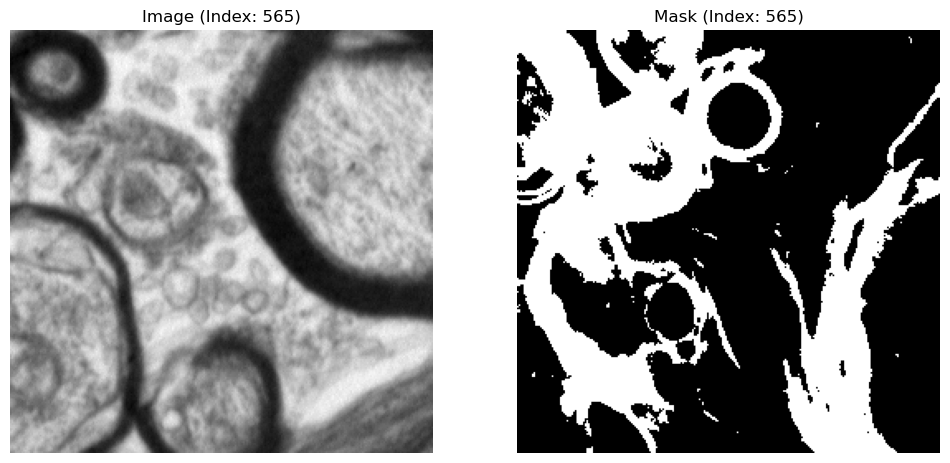

In [30]:
# Visualize a sample image and mask
random_index = np.random.randint(images_2.shape[0])

selected_image = images_2[random_index]
selected_mask = masks_2[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

AimSeg dataset:

In [31]:
print(large_images_3.shape)
print(large_masks_3.shape)

(8, 1024, 1024)
(8, 1024, 1024)


In [32]:
images_3, masks_3 = patch_large_image(large_images_3, large_masks_3)

In [33]:
print(images_3.shape)
print(masks_3.shape)

(128, 256, 256)
(128, 256, 256)


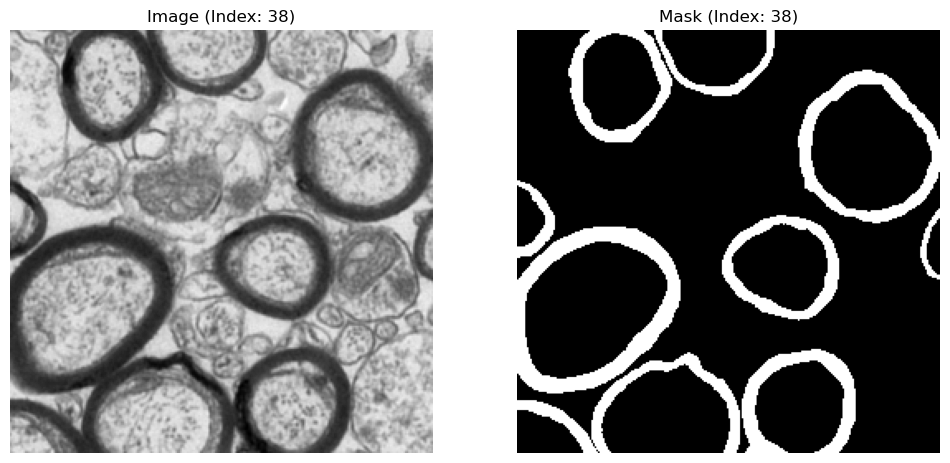

In [34]:
# Visualize a sample image and mask
random_index = np.random.randint(images_3.shape[0])

selected_image = images_3[random_index]
selected_mask = masks_3[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

AxonDeepSeg dataset

In [35]:
all_img_patches = []
for img in range(len(ads_images)):
    large_image = np.array(ads_images[img])
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images_4 = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(len(ads_masks)):
    large_mask = np.array(ads_masks[img])
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask).astype(np.uint8) #/ 255.
            all_mask_patches.append(single_patch_mask)

masks_4 = np.array(all_mask_patches)

In [36]:
print(images_4.shape)
print(masks_4.shape)

(183, 256, 256)
(183, 256, 256)


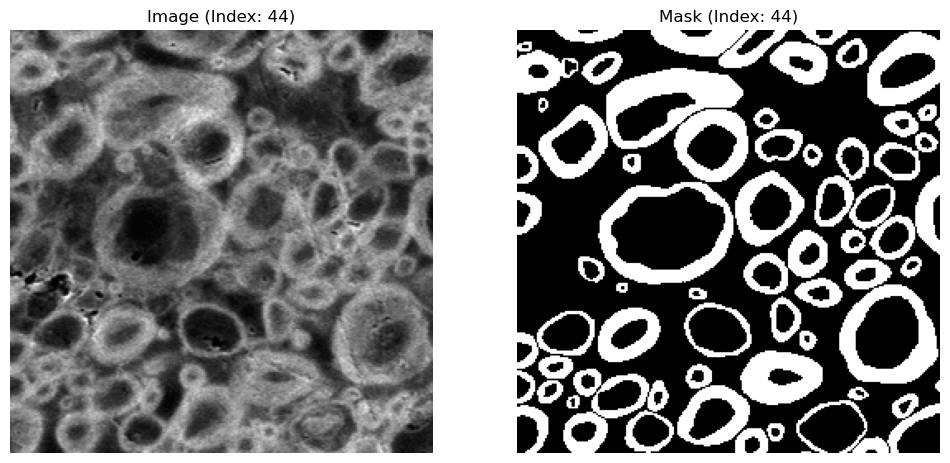

In [37]:
# Visualize a sample image and mask
random_index = np.random.randint(images_4.shape[0])

selected_image = images_4[random_index]
selected_mask = masks_4[random_index]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(selected_image, cmap='gray')
axes[0].set_title(f'Image (Index: {random_index})')
axes[0].axis('off')
axes[1].imshow(selected_mask, cmap='gray')
axes[1].set_title(f'Mask (Index: {random_index})')
axes[1].axis('off')
plt.show()

In [38]:
# Combine all images and masks into 2 numpy tensors
images = np.concatenate((images_1, images_2, images_3, images_4), axis=0)
masks = np.concatenate((masks_1, masks_2, masks_3, masks_4), axis=0)
print("Image shape:", images.shape)
print("Mask shape:", masks.shape)

Image shape: (6815, 256, 256)
Mask shape: (6815, 256, 256)


In [39]:
# Normalize Data
def image_adjust(im):
    adjusted_I = ((im - np.min(im)) * (1/(np.max(im) - np.min(im))*255.0)).astype('uint8')
    return adjusted_I

for i in tqdm(np.arange(images.shape[0])):
    images[i] = image_adjust(images[i])
# images = images / 255.

100%|████████████████████████████████████████████████████████████████████████████| 6815/6815 [00:01<00:00, 6661.76it/s]


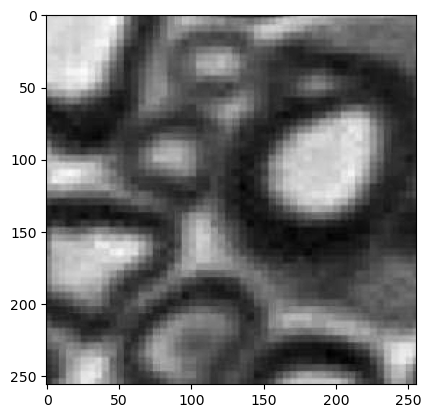

255.0


In [40]:
plt.imshow(images[300], cmap='gray')
plt.show()
print(np.max(images))

In [41]:
# save image as PNG and re-load it as Pillow image

# Create a directory to save the images if it doesn't exist
save_dir = 'png_images/'
os.makedirs(save_dir, exist_ok=True)

# save each grayscale image as a PNG file
for i, img_array in tqdm(enumerate(images)):
    img = Image.fromarray(img_array.astype(np.uint8))
    img.save(os.path.join(save_dir, f'image_{i}.png'))

rgb_images = []

# reload the images as RGB and store them back in the list
for i in tqdm(range(images.shape[0])):
    img_path = os.path.join(save_dir, f'image_{i}.png')
    img = Image.open(img_path).convert('RGB')  # Load and convert to RGB
    rgb_images.append(np.array(img))  # Convert PIL Image to numpy array and store

images = np.array(rgb_images)
print(images.shape)

6815it [00:41, 162.86it/s]
100%|█████████████████████████████████████████████████████████████████████████████| 6815/6815 [00:28<00:00, 239.25it/s]


(6815, 256, 256, 3)


Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [42]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (3707, 256, 256, 3)
Mask shape: (3707, 256, 256)


(256, 256, 3)


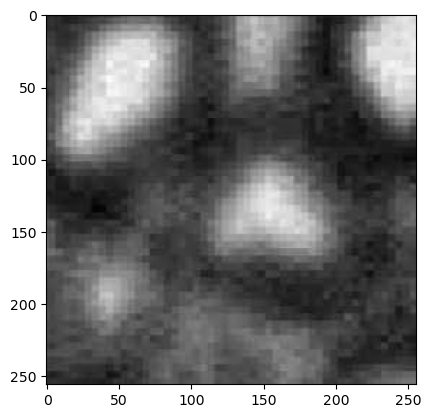

In [43]:
image_test = (filtered_images[30])
print(np.array(image_test).shape)
plt.imshow(image_test, cmap='gray')
plt.show()

In [44]:
# # def to_rgb(im):
# #     # Convert a grayscale image (2d numpy array) to an rgb one (3d numpy array)
# #     return np.dstack([im.astype(np.uint8)] * 3).copy(order='C')
# def to_rgb(im):
#     # Convert a grayscale image (2d numpy array) to an rgb one (3d numpy array)
#     w, h = im.shape
#     ret = np.empty((w, h, 3)) #, dtype=np.uint8
#     ret[:, :, 2] =  ret[:, :, 1] =  ret[:, :, 0] =  im
#     return ret

In [45]:
# # print(filtered_images[30])
# image_test = to_rgb(filtered_images[30])
# print(image_test.shape)
# # print(image_test)

In [46]:
# show_image = np.moveaxis(image_test, 0, -1)
# plt.imshow(show_image)
# plt.show()

In [47]:
# # Convert all images to rgb
# rgb_filtered_images = np.empty((3707, 256, 256, 3))

# for i in range(np.shape(filtered_images)[0]):
#     rgb_filtered_images[i] = to_rgb(filtered_images[i])

Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [48]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [49]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3707
})

In [50]:
# Enable CUDA
# %pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 -f https://download.pytorch.org/whl/torch_stable.html
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")

print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.7
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 4080


Let us make sure out images and masks (labels) are loading appropriately

In [51]:
# from datasets import load_dataset, Dataset
# from PIL import Image
# import io
# from tqdm import tqdm

# def load_and_process_dataset(dataset_name, split='train'):
#     """
#     Load a dataset from the Hugging Face Hub and convert Tiff images to Pillow images.

#     Args:
#         dataset_name (str): Name of the dataset on the Hugging Face Hub.
#         split (str, optional): Split of the dataset to load (default is 'train').

#     Returns:
#         dataset (Dataset): Dataset object from dictionary containing the loaded dataset with list of Pillow images and corresponding binary masks.
#     """
#     # Load dataset
#     dataset = load_dataset(dataset_name, split=split, streaming=False)

#     # Initialize lists to store Pillow images and corresponding labels(masks)
#     dataset_dict = {"image": [], "label": []}

#     # Iterate over the dataset
#     for data in tqdm(dataset):
#         # Convert label Tiff bytes to Pillow image
#         label_tif = Image.open(io.BytesIO(data['label_tif']))
#         # label_tif = np.fromfile(data['label_tif'])

#         if np.array(label_tif).max() != 0:
#           # Convert Tiff image bytes to Pillow image
#           # tif_image = Image.open(io.BytesIO(data['tif'])) # allow_pickle=True
#           tif_image = Image.open(io.BytesIO(data['tif']))
#           # np.frombuffer(k, dtype=i.dtype)

#           # Append Pillow image and label to the lists
#           dataset_dict["image"].append(tif_image)
#           dataset_dict["label"].append(label_tif)

#     # Create the dataset using the datasets.Dataset class
#     dataset = Dataset.from_dict(dataset_dict)

#     return dataset

In [52]:
# # Load dataset from hugging face
# dataset = load_and_process_dataset("back2classroom/sidewalks")


In [53]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3707
})

Note: Only 88,863 image patches are considered with non-empty binary masks for training.

Below, we plot some sample images along with the ground truth binary masks loaded from Huggingface.

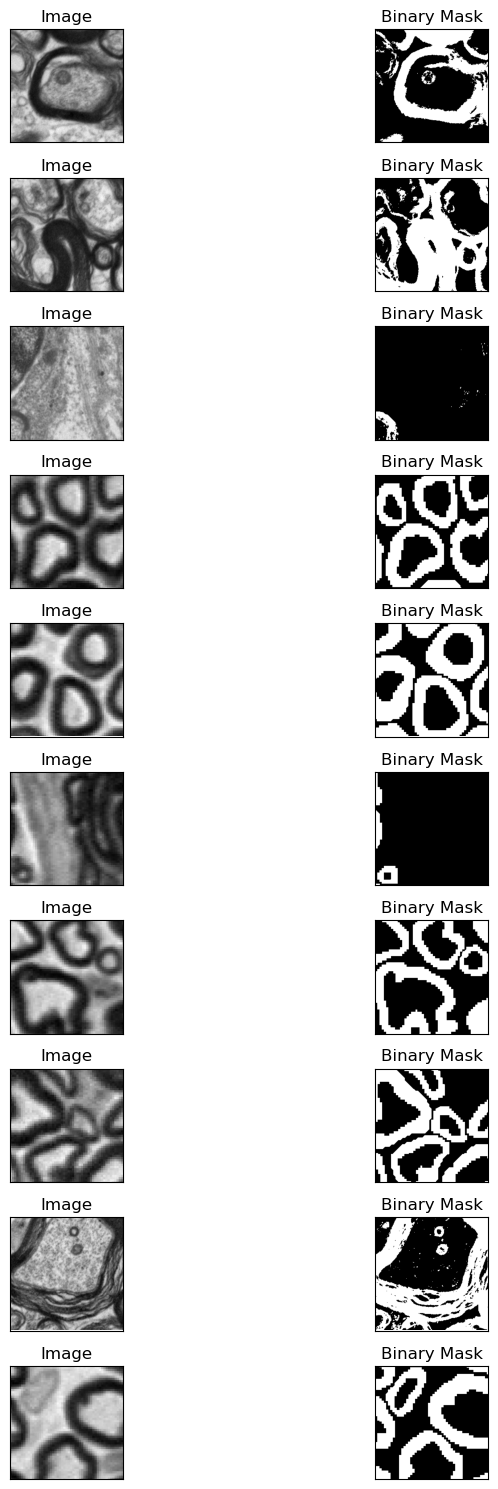

In [54]:
def plot_images_with_masks(dataset, num_images=10):
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 15))

    for i, idx in enumerate(indices):
        example_image = dataset[idx]["image"]
        example_mask = dataset[idx]["label"]
        # example_image = np.moveaxis(example_image, 0, -1)
        axes[i, 0].imshow(np.array(example_image), cmap='gray')
        axes[i, 0].set_title('Image')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].set_xticklabels([])
        axes[i, 0].set_yticklabels([])

        axes[i, 1].imshow(example_mask, cmap='gray')
        axes[i, 1].set_title('Binary Mask')
        axes[i, 1].set_xticks([])
        axes[i, 1].set_yticks([])
        axes[i, 1].set_xticklabels([])
        axes[i, 1].set_yticklabels([])

    plt.tight_layout()
    plt.show()

# Call the function to plot 10 random images with their masks
plot_images_with_masks(dataset, 10)

# Getting a Dataset Ready for Training

In [55]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [56]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [57]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [58]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [59]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [60]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
# Pin memory true since data is loaded in cpu and we need it in gpu
train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True, drop_last=False, pin_memory=True)

In [76]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

pixel_values torch.Size([12, 3, 1024, 1024])
original_sizes torch.Size([12, 2])
reshaped_input_sizes torch.Size([12, 2])
input_boxes torch.Size([12, 1, 4])
ground_truth_mask torch.Size([12, 256, 256])


In [77]:
batch["ground_truth_mask"].shape

torch.Size([12, 256, 256])

# Loading Model

In [78]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [79]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [80]:
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [73]:
# from google.colab import drive
# drive.mount('/content/drive')

In [81]:
def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
  checkpoint = {
    "epoch": epoch,
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "mean_loss": loss
  }

  torch.save(checkpoint, checkpoint_dir + f'checkpoint_at_epoch_{epoch}.pt')

In [82]:
checkpoint_dir = "model_checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)

In [83]:
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    save_checkpoint(epoch, model, optimizer, mean(epoch_losses), checkpoint_dir)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [3:10:03<00:00, 36.91s/it]


EPOCH: 0
Mean loss: 0.6899453530805396


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [2:26:50<00:00, 28.51s/it]


EPOCH: 1
Mean loss: 0.6037473520414729


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [2:27:12<00:00, 28.58s/it]


EPOCH: 2
Mean loss: 0.5808589691868877


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [2:33:22<00:00, 29.78s/it]


EPOCH: 3
Mean loss: 0.5659444842330846


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [2:43:13<00:00, 31.69s/it]


EPOCH: 4
Mean loss: 0.5545135440371183


100%|██████████████████████████████████████████████████████████████████████████████| 309/309 [3:15:49<00:00, 38.02s/it]


EPOCH: 5
Mean loss: 0.545780752758378


  3%|██▌                                                                            | 10/309 [11:00<5:28:56, 66.01s/it]


KeyboardInterrupt: 

# Runtime disconnected halfway through epoch 2, so have to stop and restart epoch 2...

In [ ]:
# Epoch 1 checkpoint has been saved, so defining a function load_checkpoint
# to get the weights and optimizer from end of Epoch 1 to resume training.

# References:
# https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/4
# https://discuss.pytorch.org/t/saving-model-and-optimiser-and-scheduler/52030

def load_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    epoch = checkpoint["epoch"]
    model.load_state_dict(checkpoint["model"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    loss = checkpoint["mean_loss"]
    return epoch, loss, model, optimizer

In [ ]:
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

In [ ]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
checkpoint_path = "/content/drive/MyDrive/AI_Project/checkpoints/checkpoint_at_epoch_0.pt"

# Load the checkpoint
epoch, loss, model, optimizer = load_checkpoint(checkpoint_path, model, optimizer)

In [ ]:
#Training loop
num_epochs = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
# Now individually transfer the optimizer parts to device...
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

model.train()

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
def save_checkpoint(epoch, model, optimizer, loss, checkpoint_dir):
  checkpoint = {
    "epoch": epoch,
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "mean_loss": loss
  }

  torch.save(checkpoint, checkpoint_dir + f'checkpoint_at_epoch_{epoch}.pt')

In [ ]:
checkpoint_dir = "/content/drive/MyDrive/AI_Project/checkpoints/"

In [ ]:
# Training epoch 2 again
for epoch in range(epoch, num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    save_checkpoint(epoch, model, optimizer, mean(epoch_losses), checkpoint_dir)

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 7406/7406 [3:19:08<00:00,  1.61s/it]


EPOCH: 0
Mean loss: -437283.2306718018


  1%|          | 38/7406 [01:01<3:20:21,  1.63s/it]


KeyboardInterrupt: 

Oops, the previous loop should have started at epoch **1** not 0, but we forgot to do epoch = epoch + 1 for display purposes previously , so the loop was continuing to the third epoch, which is stopped. Nonetheless, we now have our model trained for two epochs.

# Inference

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

We load the model weights after training for 2 epochs, to perform inference on 'val' split of sidewalks dataset.

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
sidewalk_model = SamModel(config=model_config)
# Update the model by loading the weights from saved file.
# Indexed from 0 so epoch_1 below is the second epoch
checkpoint = torch.load("/content/drive/MyDrive/SAM_sidewalk/checkpoints/checkpoint_at_epoch_1.pt")
sidewalk_model.load_state_dict(checkpoint["model"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
sidewalk_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
# Load 'val' split of dataset from hugging face
val_dataset = load_and_process_dataset("back2classroom/sidewalks", split='val')


Generating train split:   0%|          | 0/180000 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/19999 [00:00<?, ? examples/s]

100%|██████████| 19999/19999 [00:07<00:00, 2533.15it/s]


In [ ]:
val_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 10082
})

Note: Only 10,082 image patches are considered with non-empty binary masks.

**Observations:**

Now, we generate probability maps for 5 random images from the 'val' split of our custom dataset and compare it against the ground truth masks.

We test various thresholds for converting the probability masks to binary masks and threshold of 0.85 appeared to generate the best results.

We observe that with only 2 epochs of training, the model is able to generate reasonable masks for most images. However, there is a decent number of false positive predictions for pixels that do not belong to sidewalks. We believe, with enough training (for more # epochs), the model would get better but we currently stop training at 2 epochs owing to high computational complexity.

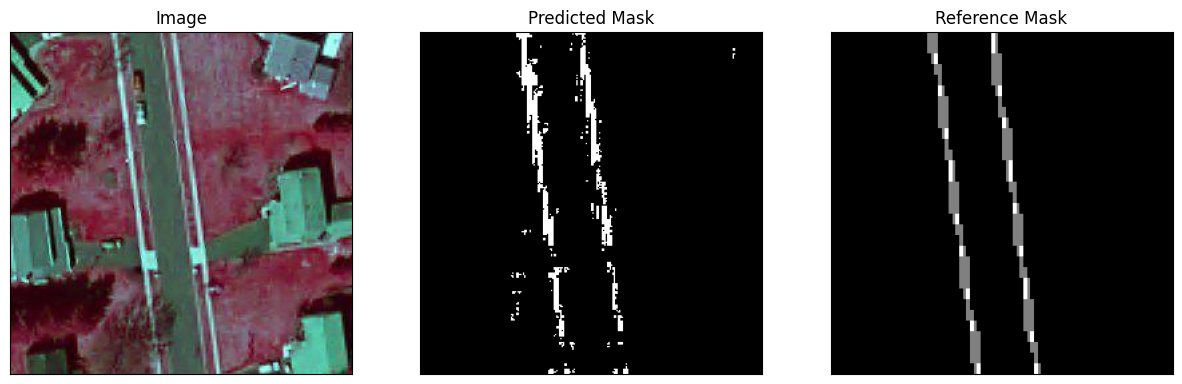

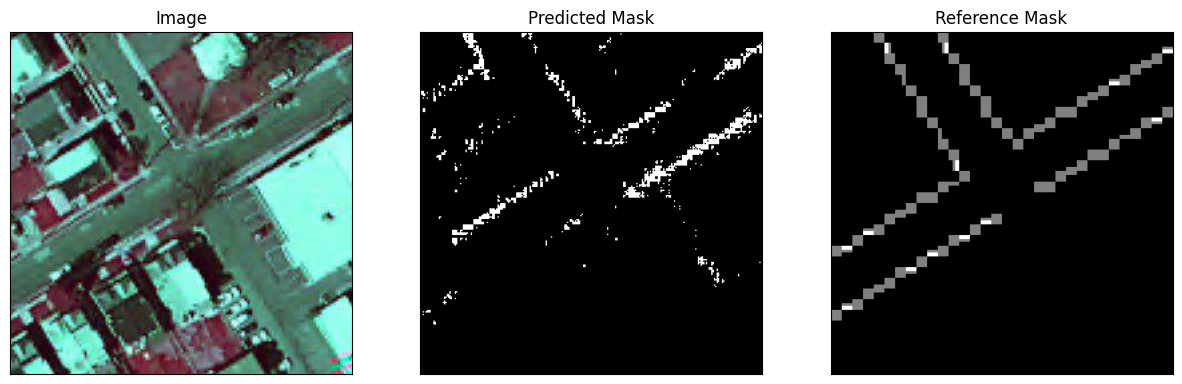

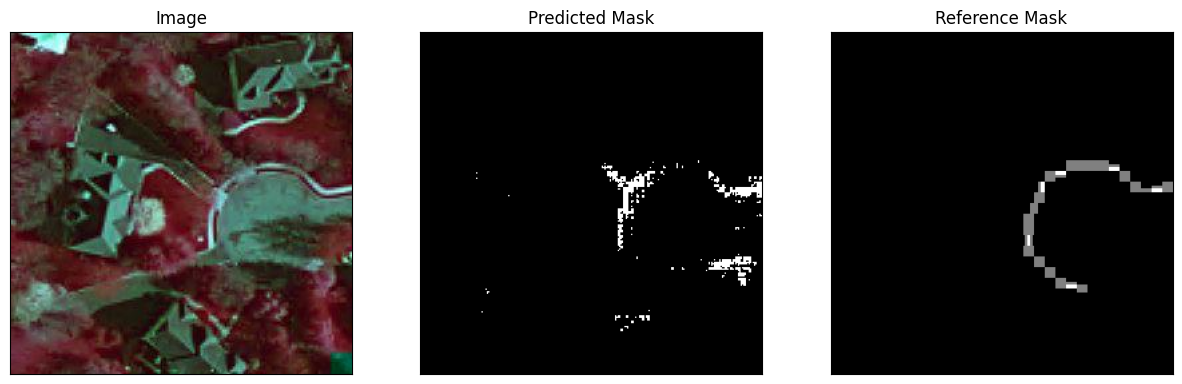

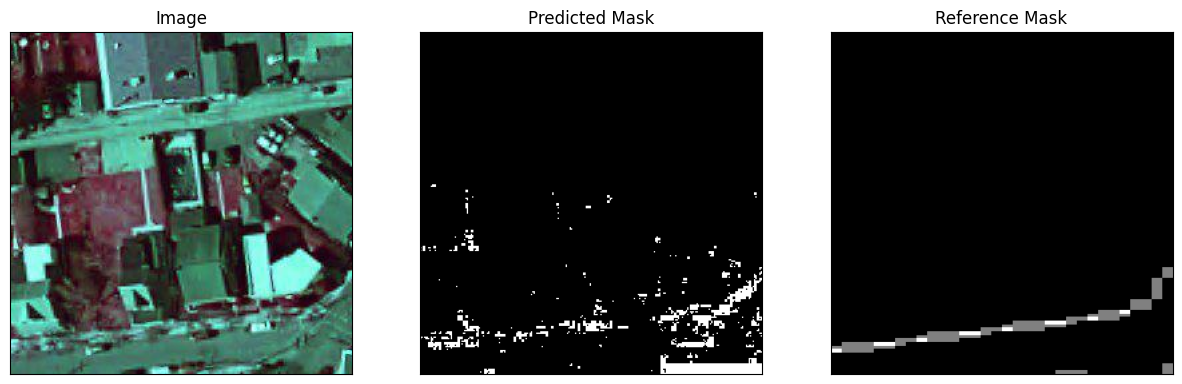

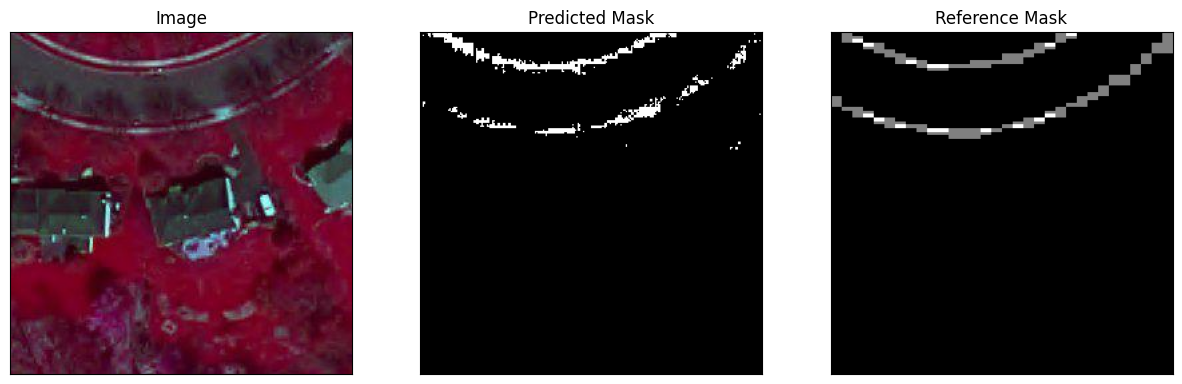

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# Predict sidewalks binary masks for 5 random samples from 'val' set
for i in range(5):
  # let's take a random sample from validation dataset
  idx = random.randint(0, 10082)

  # load image
  test_image = val_dataset[idx]["image"]

  # get box prompt based on ground truth segmentation map
  ground_truth_mask = np.array(val_dataset[idx]["label"])
  prompt = get_bounding_box(ground_truth_mask)

  # prepare image + box prompt for the model
  inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

  # Move the input tensor to the GPU if it's not already there
  inputs = {k: v.to(device) for k, v in inputs.items()}

  sidewalk_model.eval()

  # forward pass
  with torch.no_grad():
      outputs = sidewalk_model(**inputs, multimask_output=False)

  # apply sigmoid
  medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
  # convert soft mask to hard mask
  medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
  medsam_seg = (medsam_seg_prob > 0.85).astype(np.uint8)


  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  # Plot the first image on the left
  axes[0].imshow(np.array(test_image))
  axes[0].set_title("Image")

  # Plot the second image on the right
  axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
  axes[1].set_title("Predicted Mask")

  # # Plot the second image on the right
  # axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
  # axes[2].set_title("Probability Map")

  # Plot the ground truth binary mask
  axes[2].imshow(np.array(val_dataset[idx]["label"]), cmap='gray')
  axes[2].set_title("Reference Mask") # ground truth binary mask

  # Hide axis ticks and labels
  for ax in axes:
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_xticklabels([])
      ax.set_yticklabels([])

  # Display the images side by side
  plt.show()
